# Homework: Build Your Own NN Framework

The goal of this homework is simple, yet an actual implementation may take some time. We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course.

Your homework task comprises 4 steps:
 - Implement all modules in `homework_part1_modules.ipynb` . These modules will be checked automatically using tests provided in `homework_part1_test_modules.ipynb`
 - Check that your modules work on 'toy example' (see below)
 - Train small neural network to classify images from mnist dataset
 - Train the same neural network in pytorch

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# 1. Framework

Implement everything in `homework_part1_modules.ipynb`. Read all the comments thoughtfully, it will reduce the amount of time spended on debug. Please don't change the prototypes since layers you implement will be automatically checked.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so layer output is stored in `_output`. This would be useful for `SoftMax`. 

### Tech note about inplace operations
You can use `np.multiply`, `np.add`, `np.divide`, `np.subtract` with parameter `out` filled instead of `*`,`+`,`/`,`-` for better memory handling through inplace operations

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b, c, out=a) # puts result in `a`
```

In [2]:
# (re-)load layers
%run homework_part1_modules.ipynb

# 2. Toy example

Once you have implemented the modules, you can check that your framework can actually be used for neural network training. Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

## Dataset

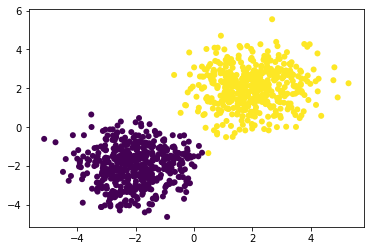

In [3]:
# Generate some data
n_samples = 500

X_pos = np.random.randn(n_samples, 2) + np.array([2, 2])
X_neg = np.random.randn(n_samples, 2) + np.array([-2, -2])
X = np.vstack([X_pos, X_neg])

Y = np.concatenate([np.ones(n_samples), np.zeros(n_samples)])[:, np.newaxis]
Y = np.hstack([Y, 1 - Y])  # one-hot encoding

plt.scatter(X[:, 0],X[:, 1], c=Y[:, 0], edgecolors='none')

## Neural network architecture

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add_module(Linear(2, 2))
net.add_module(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

#net = Sequential()
#net.add_module(Linear(2, 4))
#net.add_module(ReLU())
#net.add_module(Linear(4, 2))
#net.add_module(LogSoftMax())

Linear 2 -> 2
LogSoftMax



## Optimizer

Let's start with simple SGD with momentum. You can test Adam if sgd works fine

In [5]:
opt = SGD(net, lr=1e-1, momentum=0.9)
#opt = Adam(net)

## Training

Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

Basic training loop. Examine it.

In [7]:
def train_network(
    net,
    optimizer,
    criterion,
    X,
    Y,
    batch_size,
    n_epoch
):
    loss_history = []

    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X, Y), batch_size):

            net.zero_grad()

            # Forward
            predictions = net.forward(x_batch)
            loss = criterion.forward(predictions, y_batch)

            # Backward
            dp = criterion.backward(predictions, y_batch)
            net.backward(x_batch, dp)

            # Update weights
            optimizer.step()

            loss_history.append(loss)

        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))

        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        plt.show()

        print('Current loss: %f' % loss)    

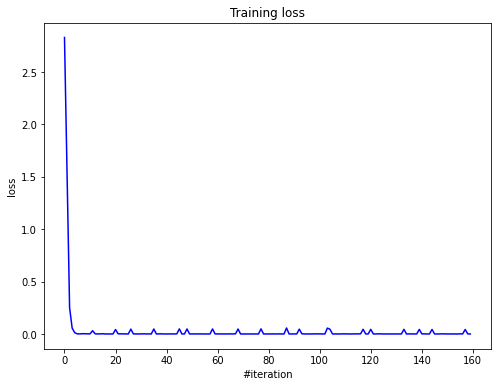

Current loss: 0.000000


In [8]:
train_network(
    net,
    opt,
    criterion,
    X,
    Y,
    batch_size=128,
    n_epoch=20
)

# 3. Classification on MNIST

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [9]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

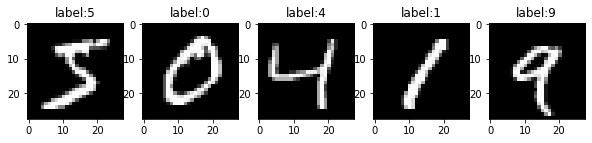

In [10]:
n_samples = 5
plt.figure(figsize=(10,4))
for i in range(n_samples):
    plt.subplot(1,n_samples,i+1)
    plt.imshow(X_train[i], 'gray')
    plt.title('label:{}'.format(y_train[i]))

Your task:
1. Preprocess data: One-hot encode the labels and reshape 28x28 images to 1D vectors of size 784
2. Define simple network Linear(128) + relu + Linear(10) + LogSoftMax
3. Define criterion ClassNLLCriterion
4. Define optimizer (sgd or adam)
5. Train network
6. Test network on test data, print its accuracy. Make sure accuracy is greater than 95% on test set

In [11]:
print(X_train.shape, y_train.shape, y_train[:10])

def one_hot_encoding(
    targets,
    num_classes
):
    mask = np.zeros((targets.shape[0], num_classes))
    mask[np.arange(targets.size), targets] = 1
    
    return mask

# YOUR CODE: reshape + one-hot encoding

X_test_reshape = np.reshape(X_test, (-1, 28*28))
X_train_reshape = np.reshape(X_train, (-1, 28*28))

num_classes = 10

y_train_encode = one_hot_encoding(y_train, num_classes)
y_test_encode = one_hot_encoding(y_test, num_classes)

assert len(X_test_reshape.shape) == 2, X_test_reshape.shape
assert len(X_test_reshape[-1]) == 28*28, X_test_reshape.shape
assert len(y_test_encode.shape) == 2, y_test_encode.shape
assert len(y_test_encode[-1]) == 10, y_test_encode.shape

assert len(X_train_reshape.shape) == 2, X_train_reshape.shape
assert len(X_train_reshape[-1]) == 28*28, X_train_reshape.shape
assert len(y_train_encode.shape) == 2, y_train_encode.shape
assert len(y_train_encode[-1]) == 10, y_train_encode.shape

(50000, 28, 28) (50000,) [5 0 4 1 9 2 1 3 1 4]


In [12]:
# YOUR CODE: network definition Linear(128) + relu + Linear(10) + LogSoftMax
net_mnist = Sequential()
net_mnist.add_module(Linear(28*28, 128))
net_mnist.add_module(ReLU())
net_mnist.add_module(Linear(128, 10))
net_mnist.add_module(LogSoftMax())

print(net_mnist)

Linear 784 -> 128
ReLU
Linear 128 -> 10
LogSoftMax



In [13]:
# YOUR CODE: criterion definition
criterion = ClassNLLCriterion()

In [14]:
# YOUR CODE: optimizer definition
# for sgd normally you can start with momentum = 0.9 or 0.99 and lr=1e-2  or 1e-1
opt_mnist = SGD(net_mnist, lr=1e-1, momentum=0.9)

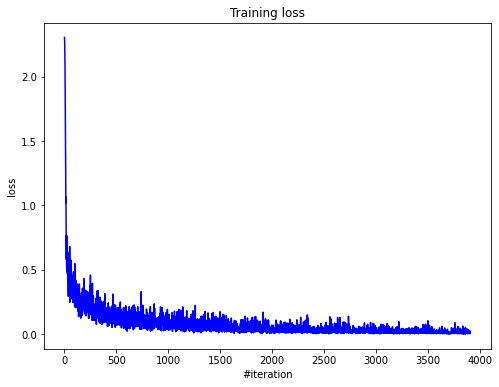

Current loss: 0.013949


In [15]:
# YOUR CODE: train network, try batch 128 and 5-15 epochs
train_network(
    net_mnist,
    opt_mnist,
    criterion,
    X_train_reshape,
    y_train_encode,
    batch_size=128,
    n_epoch=10
)

Test function is already written here for you. Check your network accuracy, it should be above 95% on test set to pass the grade.

In [16]:
def test_network(network, x_test, y_test, batch_size=1):
    n_correct = 0
    loss_hist = []
    for x_batch, y_batch in get_batches((x_test, y_test), batch_size):
        # Forward
        predictions = network.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
        loss_hist.append(loss)
        
        y_pred = np.argmax(predictions, axis=-1)
        y_true = np.argmax(y_batch, axis=-1)
        n_correct += np.sum(y_pred == y_true)
    print('Mean loss: {}'.format(np.mean(loss_hist)))    
    accuracy = n_correct * 100. / len(y_test)
    print('accuracy: {}'.format(accuracy))
    return accuracy

In [17]:
accuracy = test_network(net_mnist, X_test_reshape, y_test_encode)
assert accuracy > 95, accuracy

Mean loss: 0.08005199718122044
accuracy: 97.77


# 4. Pytorch on MNIST

Let's do the same network in pytorch

0. Preprocess data. This time gt labels should represent class indices and images should be reshaped from 28x28 images to 1D vectors of size 784.
1. Define network`Linear(784, 128) -> Relu -> Linear(128, 10) -> LogSoftMax`
  - you can find all layers in `torch.nn` module
  - the only difference from our framework will be in `Sequential.add_module` method, check its signature in documentation
2. Define criterion
  - analogue of `ClassNLLCriterion` is `torch.nn.NLLoss`, but it takes class labeles as the second parameter instead of one-hot encoded labels - that's why we need different preprocessing on step 0.
3. Define optimizer from torch.optim module
  - optimizers take a list of network parameters instead of the whole network as in our framework. You can easily get the parameters by calling `net.parameters()` method
4. Rewrite `train_network()` and `test_network()` functions so that they will be able work with pytorch network
  - just convert numpy arrays with batch data to `torch.Tensor` using `torch.from_numpy` and feed them to the network
  - result tensors can easily converted from pytorch to numpy using chain of two methods: `detach().numpy()`
  - 
5. Train your network
6. Test network on test data, print its accuracy. Make sure accuracy is greater than 95% on test set

In [18]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset()

In [19]:
print(X_train.shape, y_train.shape, y_train[:10])

def one_hot_encoding(
    targets,
    num_classes
):
    mask = np.zeros((targets.shape[0], num_classes))
    mask[np.arange(targets.size), targets] = 1
    
    return mask

# YOUR CODE: reshape + one-hot encoding

X_test_reshape = np.reshape(X_test, (-1, 28*28))
X_train_reshape = np.reshape(X_train, (-1, 28*28))

num_classes = 10

y_train_encode = one_hot_encoding(y_train, num_classes)
y_test_encode = one_hot_encoding(y_test, num_classes)

assert len(X_test_reshape.shape) == 2, X_test_reshape.shape
assert len(X_test_reshape[-1]) == 28*28, X_test_reshape.shape
assert len(y_test_encode.shape) == 2, y_test_encode.shape
assert len(y_test_encode[-1]) == 10, y_test_encode.shape

assert len(X_train_reshape.shape) == 2, X_train_reshape.shape
assert len(X_train_reshape[-1]) == 28*28, X_train_reshape.shape
assert len(y_train_encode.shape) == 2, y_train_encode.shape
assert len(y_train_encode[-1]) == 10, y_train_encode.shape

(50000, 28, 28) (50000,) [5 0 4 1 9 2 1 3 1 4]


In [20]:
import torch

In [21]:
# YOUR CODE define network Linear(128) + relu + Linear(10) + LogSoftmax 
net_torch = torch.nn.Sequential()
net_torch.add_module('fc1', torch.nn.Linear(28*28, 128))
net_torch.add_module('relu', torch.nn.ReLU())
net_torch.add_module('fc2', torch.nn.Linear(128, 10))
# net_torch.add_module('log_softmax', torch.nn.LogSoftmax())

print(net_torch)

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [22]:
# YOUR CODE: define criterion
criterion_torch = torch.nn.CrossEntropyLoss()

In [23]:
# YOUR CODE: define optimizer
optimizer = torch.optim.SGD(net_torch.parameters(), lr=0.1, momentum=0.9)

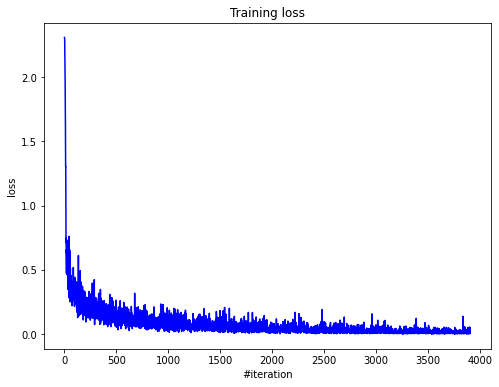

Current loss: 0.017695


In [24]:
def train_network_pytorch(
    net,
    opt,
    criterion,
    X,
    Y,
    batch_size,
    n_epoch
):
    loss_history = []

    for i in range(n_epoch):
        for x_batch, y_batch in get_batches((X, Y), batch_size):
            
            x_batch, y_batch = torch.Tensor(x_batch), torch.Tensor(y_batch)
            
            # YOUR CODE: rewrite train_network() function to be able to work with pytorch network
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward
            predictions = net(x_batch)
            loss = criterion(predictions, y_batch)
            
            loss_history.append(loss.detach().numpy())

            # Backward
            loss.backward()

            # Update weights
            optimizer.step()
            

        # Visualize
        display.clear_output(wait=True)
        plt.figure(figsize=(8, 6))

        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        plt.show()

        print('Current loss: %f' % loss)    
        
train_network_pytorch(
    net_torch,
    optimizer,
    criterion_torch,
    X_train_reshape,
    y_train_encode,
    128,
    10
)

In [25]:
def test_network_pytorch(
    network,
    criterion,
    x_test,
    y_test,
    batch_size=1
):
    n_correct = 0
    loss_hist = []
    
    network.eval()

    for x_batch, y_batch in get_batches((x_test, y_test), batch_size):
        # YOUR CODE: rewrite test_network() function to be able to work with pytorch network
        with torch.no_grad():
            x_batch, y_batch = torch.Tensor(x_batch), torch.Tensor(y_batch)
            
            # Forward
            predictions = network(x_batch)
            loss = criterion(predictions, y_batch)
            loss_hist.append(loss)

            y_pred = torch.argmax(predictions, axis=1)
            y_true = torch.argmax(y_batch, axis=1)
            n_correct += torch.sum(y_pred == y_true)

    print('Mean loss: {}'.format(np.mean(loss_hist)))    
    accuracy = n_correct * 100. / len(y_test)
    print('accuracy: {}'.format(accuracy))
    return accuracy

Check your network accuracy, it should be above 95% on test set to pass the grade.

In [26]:
accuracy = test_network_pytorch(
    net_torch,
    criterion_torch,
    X_test_reshape,
    y_test_encode
)
assert accuracy > 95, accuracy

Mean loss: 0.07668144255876541
accuracy: 97.80000305175781
